In [2]:
import data_extractor
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt
import importlib
import os
import saveload_workspace

## Define parameters and settings

In [3]:
root_wd = os.getcwd() # current wd should be model folder
data_directory = os.path.join(root_wd, '..', 'Symmetric Experiment Data')
file_names = [name for name in os.listdir(data_directory) if name.endswith('mat')]
file_indexes = np.arange(12)
Condition_Dictionary = {0: 'Short Symmetric', 1: 'Medium Symmetric', 2: 'Long Symmetric'}
Condition_Colors_Dict = {0: '#0BB8FD', 1: '#FD8B0B', 2: '#E35D72'}
Condition_Time_Dictionary = {0: 500, 1: 850, 2: 1500}
Condition_Trials = [[50, 200], [200, 350], [350, 500]]
Subject_Dict = {0: 'Predator', 1: 'Prey'}
SAMPLE_TIME = 10  # samples coordinate data every 10ms

## Define functions

In [4]:

# function to obtain data samples 
def prepare_data(decisions_data, x_data, y_data, x_vel_data, y_vel_data, seq_size, condition_no, role_no, include_velocity):
    trial_sample_length = int(Condition_Time_Dictionary[condition_no] / SAMPLE_TIME)
    time_dataset, x_dataset, y_dataset, x_vel_dataset, y_vel_dataset, label_data = [], [], [], [], [], []
    for file_no in range(len(file_indexes)):
        x_sample_data = np.array(x_data[file_no, condition_no, :, role_no, :])
        y_sample_data = np.array(y_data[file_no, condition_no, :, role_no, :])
        x_vel_sample_data = np.array(x_vel_data[file_no, condition_no, :, role_no, :])
        y_vel_sample_data = np.array(y_vel_data[file_no, condition_no, :, role_no, :])
        for trial in range(decisions_data.shape[2]):
            for start_idx in range(trial_sample_length - seq_size):
                if not (np.isnan(np.sum(x_sample_data[trial, start_idx: start_idx + seq_size])) or \
                        np.isnan(np.sum(x_vel_sample_data[trial, start_idx: start_idx + seq_size]))):
                    
                    time_dataset.append(np.arange(start_idx, start_idx + seq_size) / (trial_sample_length - 1))
                    x_dataset.append(x_sample_data[trial, start_idx: start_idx + seq_size])
                    y_dataset.append(y_sample_data[trial, start_idx: start_idx + seq_size])
                    x_vel_dataset.append(x_vel_sample_data[trial, start_idx: start_idx + seq_size])
                    y_vel_dataset.append(y_vel_sample_data[trial, start_idx: start_idx + seq_size])
                    
                    one_hot_encode = np.zeros(3)
                    one_hot_encode[int(decisions_data[file_no, condition_no, trial, role_no])] = 1
                    label_data.append(one_hot_encode)

    x_dataset_array = np.array(x_dataset)
    y_dataset_array = np.array(y_dataset)
    x_vel_dataset_array = np.array(x_vel_dataset)
    y_vel_dataset_array = np.array(y_vel_dataset)
    time_dataset_array = np.array(time_dataset)
    
    if include_velocity:
        input_data_raw = np.array([time_dataset_array, x_dataset_array, y_dataset_array, x_vel_dataset_array, y_vel_dataset_array]).transpose(1, 2, 0)
        x_dataset_norm = (x_dataset_array - np.min(x_dataset_array)) / (np.max(x_dataset_array) - np.min(x_dataset_array))
        y_dataset_norm = (y_dataset_array - np.min(y_dataset_array)) / (np.max(y_dataset_array) - np.min(y_dataset_array))
        x_vel_dataset_norm = (x_vel_dataset_array - np.min(x_vel_dataset_array)) / (np.max(x_vel_dataset_array) - np.min(x_vel_dataset_array))
        y_vel_dataset_norm = (y_vel_dataset_array - np.min(y_vel_dataset_array)) / (np.max(y_vel_dataset_array) - np.min(y_vel_dataset_array))
        input_data = np.array([time_dataset, x_dataset_norm, y_dataset_norm, x_vel_dataset_norm, y_vel_dataset_norm]).transpose(1, 2, 0)
    else:
        input_data_raw = np.array([time_dataset_array, x_dataset_array, y_dataset_array]).transpose(1, 2, 0)
        x_dataset_norm = (x_dataset_array - np.min(x_dataset_array)) / (np.max(x_dataset_array) - np.min(x_dataset_array))
        y_dataset_norm = (y_dataset_array - np.min(y_dataset_array)) / (np.max(y_dataset_array) - np.min(y_dataset_array))
        input_data = np.array([time_dataset, x_dataset_norm, y_dataset_norm]).transpose(1, 2, 0)

    return input_data_raw, input_data, np.array(label_data) 

# function to plot trajectory samples
def plot_trajectory_sample(input_data_raw_, sample_list):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')
    ax.axis('equal')
    ax.add_patch(plt.Circle((0, 0), 0.008, color='k', linewidth=2, fill=False))
    ax.add_patch(plt.Circle((0.1, 0.15), 0.022, color='k', linewidth=4, fill=False))
    ax.add_patch(plt.Circle((-0.1, 0.15), 0.022, color='k', linewidth=4, fill=False))
    
    for sample_no in sample_list:
        ax.plot(input_data_raw_[sample_no, :, 1], input_data_raw_[sample_no, :, 2], linewidth=3.0, color='tomato')

    ax.set_ylim((-0.01, 0.18))
    ax.set_xlim((-0.15, 0.15))

# function to plot prediction accuracies versus normalized time
def plot_predictionprobability(prob_data, input_data_, label_data_):
    time_bins = np.arange(0, 1, input_data[0, 1, 0] / 2)
    prediction_accuracy = np.sum(prob_data * label_data_, axis=1)
    prediction_trial_time = np.mean(input_data_[:, :, 0], axis=1)
    prediction_time_bins = np.digitize(prediction_trial_time, bins=time_bins)
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Normalized Time (%)')
    ax.set_ylabel('Decision prediction probability')
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 100)) 
    ax.scatter(prediction_trial_time * 100, prediction_accuracy, color=Condition_Colors_Dict[condition_no], s=0.1)
    
    time_bin_centers = (time_bins[1:] + time_bins[:-1]) / 2 * 100
    df = pd.DataFrame({'pred_time': prediction_trial_time, 'pred_bin': prediction_time_bins, 'pred_accuracy': prediction_accuracy})
    
    bin_means = df.groupby('pred_bin').agg({'pred_accuracy': ['mean', 'min', 'max']})
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Normalized Time (%)')
    ax.set_ylabel('Mean decision prediction probability')
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 100)) 
    ax.plot(time_bin_centers[bin_means.index.values], bin_means.iloc[:, 0], color=Condition_Colors_Dict[condition_no], linewidth=2)



## Extract coordinate and decisions data

In [10]:
decisions_data, x_data, y_data, x_vel_data, y_vel_data = data_extractor.extract_data(directory=data_directory, file_indexes=file_indexes,
                                                             sample_time=SAMPLE_TIME, Condition_Dictionary=Condition_Dictionary,
                                                             Condition_Time_Dictionary=Condition_Time_Dictionary,
                                                             Condition_Trials=Condition_Trials)
os.chdir(root_wd)

Extracting trajectory and decision data
Running file no 0
Running condition no: 0 and type: 0
Running condition no: 1 and type: 1
Running condition no: 2 and type: 2
Running file no 1
Running condition no: 0 and type: 2
Running condition no: 1 and type: 0
Running condition no: 2 and type: 1
Running file no 2
Running condition no: 0 and type: 0
Running condition no: 1 and type: 2
Running condition no: 2 and type: 1
Running file no 3
Running condition no: 0 and type: 1
Running condition no: 1 and type: 2
Running condition no: 2 and type: 0
Running file no 4
Running condition no: 0 and type: 1
Running condition no: 1 and type: 0
Running condition no: 2 and type: 2
Running file no 5
Running condition no: 0 and type: 2
Running condition no: 1 and type: 1
Running condition no: 2 and type: 0
Running file no 6
Running condition no: 0 and type: 0
Running condition no: 1 and type: 1
Running condition no: 2 and type: 2
Running file no 7
Running condition no: 0 and type: 2
Running condition no: 1 

## Saving data variables

In [11]:
save_variables = ['decisions_data', 'x_data', 'y_data', 'x_vel_data', 'y_vel_data']
save_directory = root_wd + '\Saved Variables and Data\Coord and Decision Data'
save_name = 'data_workspace'
saveload_workspace.save_workspace(workspace=save_variables, globals=globals(), save_directory=save_directory,
                                   save_session_name=save_name)

decisions_data
x_data
y_data
x_vel_data
y_vel_data


## Loading data variables

In [12]:
save_directory = root_wd + '\Saved Variables and Data\Coord and Decision Data'
save_name = 'data_workspace'
variables = saveload_workspace.return_workspace(saved_directory=save_directory, saved_session_name=save_name)
for variable in variables:
    globals()[variable] = variables[variable]

decisions_data
x_data
y_data
x_vel_data
y_vel_data


## Create input and label data


In [13]:
sequence_size = 10  # samples in a window of 100 ms
condition_no = 2 # 0 - short condition, 1 - medium condition, 2 - long condition
role_no = 0 # 0 - predator role, 1 = prey role
include_velocity = True # whether to include velocity data as input for RNN
input_data_raw, input_data, label_data = prepare_data(decisions_data=decisions_data, x_data=x_data, y_data=y_data, x_vel_data=x_vel_data, y_vel_data=y_vel_data,\
                                                      seq_size=sequence_size, condition_no=condition_no, role_no=role_no, include_velocity=include_velocity)

## Trajectory sample visualizer

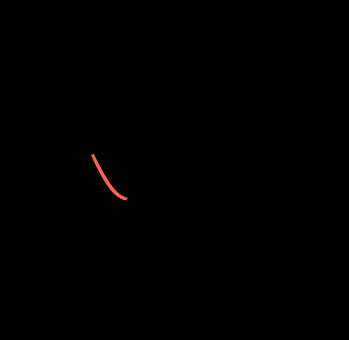

In [14]:
plot_trajectory_sample(input_data_raw_=input_data_raw, sample_list=[399, 400, 401, 403, 404])


## Splitting into train and test data

In [15]:
TRAIN_PERCENTAGE = 0.8 # proportion of samples to train on
TRAIN_SAMPLES = int(TRAIN_PERCENTAGE * label_data.shape[0])
train_indexes = np.random.choice(np.arange(label_data.shape[0]), size=TRAIN_SAMPLES, replace=False)
test_indexes = np.setdiff1d(np.arange(label_data.shape[0]), train_indexes)
input_data_train, label_data_train = input_data[train_indexes, :], label_data[train_indexes, :] # training data
input_data_test, label_data_test = input_data[test_indexes, :], label_data[test_indexes, :] # test data

## Train model

In [16]:
model = Sequential()
model.add(LSTM(64, input_shape=(input_data_train.shape[1], input_data_train.shape[2])))
model.add(Dropout(0.6))
model.add(Dense(label_data_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(x=input_data_train, y=label_data_train, epochs=50, batch_size=128)

Epoch 1/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.7528
Epoch 2/50
1575/1575 [==============================] - 10s 7ms/step - loss: 0.7167
Epoch 3/50
1575/1575 [==============================] - 9s 6ms/step - loss: 0.7069
Epoch 4/50
1575/1575 [==============================] - 9s 5ms/step - loss: 0.6936
Epoch 5/50
1575/1575 [==============================] - 14s 9ms/step - loss: 0.6773
Epoch 6/50
1575/1575 [==============================] - 9s 6ms/step - loss: 0.6690
Epoch 7/50
1575/1575 [==============================] - 10s 7ms/step - loss: 0.6632
Epoch 8/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.6604
Epoch 9/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.6569
Epoch 10/50
1575/1575 [==============================] - 10s 6ms/step - loss: 0.6555
Epoch 11/50
1575/1575 [==============================] - 9s 6ms/step - loss: 0.6525
Epoch 12/50
1575/1575 [==============================] - 10s 6ms/step - loss: 

## Test model


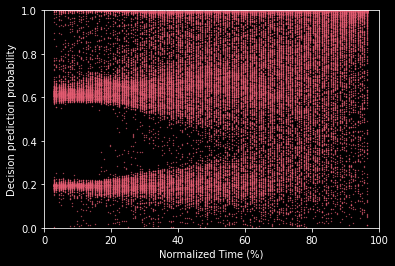

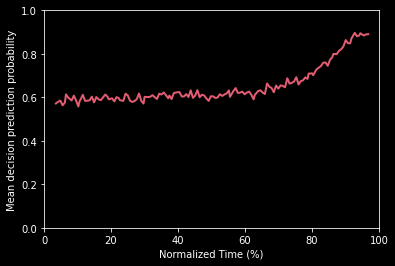

In [17]:
test_data_predictions = model.predict(x=input_data_test)
plot_predictionprobability(prob_data=test_data_predictions, input_data_=input_data_test, label_data_=label_data_test)